In [140]:
import json

import bz2
import regex
# Отслеживать прогресс
from tqdm import tqdm
from tqdm.notebook import tqdm
tqdm.pandas()
from scipy import sparse
from nltk import ngrams
import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

In [6]:
# Загружаем данные
responses = []
with bz2.BZ2File('/Users/kseniagorchakova/Library/Mobile Documents/com~apple~CloudDocs/Education/!Profession_DS/Обработка естественного языка/Лекция_3/HW_lecture_3/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:15, 2657.14it/s]


In [5]:
# Посмотрим на пример отзыва
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Анализ текстов
### 1. Посчитайте количество отзывов в разных городах и на разные банки

In [7]:
from collections import Counter

In [27]:
# количество отзывов в городах
counter_city = Counter(response['city'] for response in responses)
counter_city.most_common()

[('г. Москва', 55354),
 (None, 15174),
 ('г. Санкт-Петербург', 14342),
 ('г. Екатеринбург', 2337),
 ('г. Новосибирск', 2300),
 ('г. Нижний Новгород', 1976),
 ('г. Ростов-на-Дону', 1891),
 ('г. Самара', 1731),
 ('г. Челябинск', 1507),
 ('г. Казань', 1440),
 ('г. Краснодар', 1262),
 ('г. Уфа', 1246),
 ('г. Красноярск', 1236),
 ('г. москва', 1217),
 ('г. Воронеж', 1210),
 ('г. Пермь', 1163),
 ('г. Волгоград', 1014),
 ('г. Омск', 989),
 ('г. Саратов', 933),
 ('г. Иркутск', 749),
 ('г. Калининград', 746),
 ('г. Ставрополь', 696),
 ('г. Хабаровск', 681),
 ('г. Тюмень', 656),
 ('г. Владивосток', 637),
 ('г. Ярославль', 609),
 ('г. Барнаул', 609),
 ('г. Тула', 586),
 ('г. Томск', 569),
 ('г. Рязань', 548),
 ('г. Ульяновск', 500),
 ('г. Тольятти', 473),
 ('г. Липецк', 461),
 ('г. Иваново', 458),
 ('г. Ижевск', 454),
 ('г. Тверь', 447),
 ('г. Мурманск', 434),
 ('г. Пенза', 433),
 ('г. Оренбург', 431),
 ('г. Чебоксары', 392),
 ('г. Кемерово', 390),
 ('г. Белгород', 387),
 ('г. Магнитогорск', 379)

In [28]:
# количество отзывов на банки
counter_banks = Counter(response['bank_name'] for response in responses)
counter_banks.most_common()

[('Сбербанк России', 26327),
 ('Альфа-Банк', 10224),
 ('ВТБ 24', 8185),
 ('Русский Стандарт', 7943),
 ('Хоум Кредит Банк', 7549),
 ('Тинькофф Банк', 5387),
 ('Национальный Банк «Траст»', 4607),
 ('Ренессанс Кредит', 3849),
 ('Связной Банк', 3775),
 ('ОТП Банк', 3237),
 ('Восточный Экспресс Банк', 3138),
 ('Райффайзенбанк', 3057),
 ('Московский Кредитный Банк', 2944),
 ('Ситибанк', 2848),
 ('Авангард', 2733),
 ('Промсвязьбанк', 2586),
 ('ЮниКредит Банк', 2488),
 ('Банк Москвы', 2456),
 ('Ханты-Мансийский банк Открытие', 2158),
 ('МТС Банк', 1870),
 ('Киви Банк', 1741),
 ('Кредит Европа Банк', 1683),
 ('Росбанк', 1658),
 ('Бинбанк', 1646),
 ('БИНБАНК кредитные карты', 1464),
 ('Сетелем Банк', 1351),
 ('Московский Областной Банк', 1277),
 ('Юниаструм Банк', 1111),
 ('Современный Коммерческий Банк (бывш. ДжиИ Мани Банк)', 993),
 ('Уралсиб', 989),
 ('АйМаниБанк', 925),
 ('Совкомбанк', 919),
 ('Абсолют Банк', 782),
 ('МДМ Банк', 776),
 ('Русфинанс Банк', 723),
 ('Русславбанк', 715),
 ('2Т Ба

### 2. Постройте гистограмы длин слов в символах и в словах

In [187]:
# Преобразуем наши данные в датафрейм
data_res = pd.read_json('/Users/kseniagorchakova/Library/Mobile Documents/com~apple~CloudDocs/Education/!Profession_DS/Обработка естественного языка/Лекция_3/HW_lecture_3/banki_responses.json.bz2', lines=True)

In [188]:
# Посчитаем длину отзывов в символах
count = data_res['text'].apply(len)
count[:10]

0    1112
1    2500
2    3950
3    1341
4    1483
5    1523
6    1026
7    3172
8    1758
9     568
Name: text, dtype: int64

<AxesSubplot:ylabel='Frequency'>

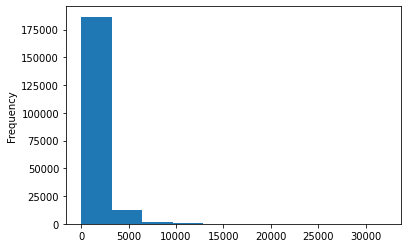

In [194]:
count.plot(kind = 'hist', bins = 10)

In [210]:
# Посчитаем длину в словах
only_word = data_res.text.astype('str').progress_apply(words_only)
count_word = only_word.apply(len)
count_word[:10]

  0%|          | 0/201030 [00:00<?, ?it/s]

0    1079
1    2343
2    3820
3    1260
4    1387
5    1432
6     971
7    2873
8    1646
9     530
Name: text, dtype: int64

<AxesSubplot:ylabel='Frequency'>

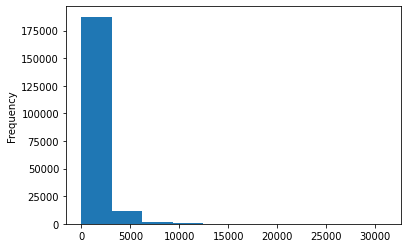

In [211]:
count_word.plot(kind = 'hist', bins = 10)

### 3. Найдите 10 самых частых:
- слов
- слов без стоп-слов
- лемм
- существительных

In [8]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kseniagorchakova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
from nltk.tokenize import word_tokenize

In [10]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kseniagorchakova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [64]:
from nltk.corpus import stopwords
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [56]:
# 10 частых слов,также приводим к нижнему регистру
corpus = [token for response in responses for token in word_tokenize(response['text'].lower()) if token not in punctuation]

In [58]:
freq_dict = Counter(corpus)
freq_dict.most_common(10)

[('в', 1322516),
 ('и', 1054485),
 ('не', 851742),
 ('на', 704396),
 ('что', 621783),
 ('я', 573896),
 ('с', 454545),
 ('по', 365188),
 ('мне', 320695),
 ('банка', 263958)]

In [65]:
noise = stopwords.words('russian') + list(punctuation) + [' ', '\n']

In [59]:
# 10 частых слов (исключаем стоп-слова), также приводим к нижнему регистру
corpus_wo_stop_words = [token for response in responses for token in word_tokenize(response['text'].lower()) if token not in noise]

In [60]:
freq_dict_wo_stop_words = Counter(corpus_wo_stop_words)
freq_dict_wo_stop_words.most_common(10)

[('банка', 263958),
 ('``', 220777),
 ("''", 215530),
 ('банк', 196303),
 ('это', 183054),
 ('деньги', 130061),
 ('...', 113647),
 ('карту', 104947),
 ('карты', 100877),
 ('кредит', 80281)]

In [ ]:
# Проведем лематизацию и посчитаем частотность слов в начальной форме

In [12]:
import pymorphy2

m = pymorphy2.MorphAnalyzer()

In [72]:
# Делаем лемматизацию и избавляемся от стоп-слов
lemmas = [m.parse(word)[0].normal_form for response in responses for word in response['text'].split() if word not in noise ]

In [73]:
# Топ 10 лемм
freq_dict_lemmas = Counter(lemmas)
freq_dict_lemmas.most_common(10)

[('банк', 395662),
 ('карта', 219718),
 ('это', 187914),
 ('я', 187889),
 ('мой', 171085),
 ('в', 154254),
 ('который', 142638),
 ('деньга', 128634),
 ('отделение', 109285),
 ('сотрудник', 109248)]

In [81]:
# Топ 10 существительных
lemmas_noun = [m.parse(word)[0].normal_form for response in responses for word in response['text'].split() if 'NOUN' in m.parse(word)[0].tag and word not in noise ]

In [82]:
freq_dict_lemmas_noun = Counter(lemmas_noun)
freq_dict_lemmas_noun.most_common(10)

[('банк', 395662),
 ('карта', 219718),
 ('деньга', 128634),
 ('отделение', 109285),
 ('сотрудник', 109248),
 ('счёт', 95008),
 ('кредит', 94558),
 ('день', 93745),
 ('сумма', 86175),
 ('клиент', 81409)]

### 4. Постройте кривые Ципфа и Хипса

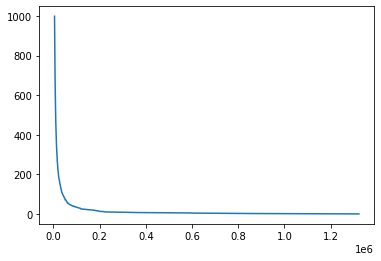

In [93]:
# Закон Ципфа
import matplotlib.pyplot as plt
%matplotlib inline

freqs = list(freq_dict.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:1000], range(1000))
plt.show()

In [13]:
# Преобразуем наши данные в датафрейм
data = pd.read_json('/Users/kseniagorchakova/Library/Mobile Documents/com~apple~CloudDocs/Education/!Profession_DS/Обработка естественного языка/Лекция_3/HW_lecture_3/banki_responses.json.bz2', lines=True)

In [14]:
data.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Воронеж,True,Ипотека на 5+,0,лицензия № 1623,e.novikova,ВТБ 24,2015-06-08 11:06:56,Здравствуйте! Хотелось бы выразить благодарно...,5.0
1,г. Казань,True,ЗВОНКИ СОСЕДЯМ,0,лицензия № 2289,KZN\Vorontsova_NA,Русский Стандарт,2015-06-06 18:17:52,Уважаемые представители департамента по работе...,2.0
2,г. Санкт-Петербург,True,Ложная информация!!!!,0,лицензия № 2307,Evgenia15,Союз,2015-06-07 19:08:33,Здравствуйте. Столкнулась с такой ситуацией. в...,2.0
3,г. Москва,True,Банкомат не зачислил деньги на счет,1,лицензия № 2557,dolgov.work,Ситибанк,2015-06-07 19:22:00,1 июня 2015 в Москве в отделении по адресу Смо...,1.0
4,г. Волгоград,True,Невозможно закрыть карту 2(два)!!!,0,лицензия № 3354,copLine,Ренессанс Кредит,2015-06-08 14:54:55,История очень долгая! Пришел я в банк (это раз...,1.0


In [42]:
# Закон Хипса
cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(data.iterrows(), total = len(data)):
    tokens = word_tokenize(row['text'])
    cnt.update([token for token in tokens if token not in punctuation])
    n_words.append(len(cnt))
    n_tokens.append(sum(cnt.values()))

100%|██████████| 201030/201030 [07:10<00:00, 467.14it/s]


In [ ]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
plt.show()

### 5. Ответьте на следующие вопросы:
#### Какое слово встречается чаще, "сотрудник" или "клиент"

In [83]:
freq_dict_lemmas_noun["сотрудник"]

109248

In [84]:
freq_dict_lemmas_noun["клиент"]

81409

Слово "сотрудник" встречается чаще чем слово "клиент"

#### Cколько раз встречается слова "мошенничество" и "доверие"

In [85]:
freq_dict_lemmas_noun["мошенничество"]

1429

In [86]:
freq_dict_lemmas_noun["доверие"]

1440

Слово "доверие" встречается чаще чем "мошенничество"

### 6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру tf−idf, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import ngrams

In [67]:
# Предоброботка текста
mystopwords = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой'
]
ru_words = re.compile("[А-Яа-я]+")

# Убираем символы
def words_only(text):
    return " ".join(ru_words.findall(text))

# Проводим лемматизацию
def lemmatize(text):
    try:
        return  " ".join([m.parse(w)[0].normal_form for w in text.lower().split()])
    except:
        return " "

# Убираем стоп слова
def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

# Соединяем 3 верхних шага   
def preprocess(text):
    return remove_stopwords(lemmatize(words_only(text.lower())))

In [74]:
# Отберем отзывы с оценкой = 1
data_est_1 = data[['text', 'rating_grade']].loc[data['rating_grade'] == 1]
data_est_1.head()

,text,rating_grade
3,1 июня 2015 в Москве в отделении по адресу Смо...,1.0
4,История очень долгая! Пришел я в банк (это раз...,1.0
10,В ИнтерБыстробанке удобно оплачивать ком. плат...,1.0
12,"Вы хотя бы читали что пишут те, кому вы обязан...",1.0
13,Здравствуйте. Сразу скажу что отношение к сбер...,1.0


In [78]:
# Проводим препроцессинг данных
data_est_1.text = data_est_1.text.astype('str').progress_apply(preprocess)
data_est_1.head()

  0%|          | 0/72307 [00:00<?, ?it/s]

,text,rating_grade
3,июнь москва отделение адрес смоленский сенной ...,1.0
4,история очень долгий прийти банк маязакрывать ...,1.0
10,интербыстробанк удобно оплачивать платёж польз...,1.0
12,хотя читать писать обязать оказывать услуга пр...,1.0
13,здравствуйте сразу сказать отношение сбер стро...,1.0


In [96]:
# Разбиваем на униграммы
vec_word = TfidfVectorizer(ngram_range=(1, 1))
bow_est_1 = vec.fit_transform(data_est_1.text)

In [102]:
# Выводим ключевые слова для отзывов с оценкой 1
terms = vec_word.get_feature_names()

# sum tfidf frequency of each term through documents
sums = bow_est_1.sum(axis=0)

# connecting term to its sums frequency
df = []
for col, term in enumerate(terms):
    df.append( (term, sums[0,col] ))

ranking = pd.DataFrame(df, columns=['term','rank'])
sort = ranking.sort_values('rank', ascending=False)
sort[:20]

,term,rank
2563,бко,5706.991531
19626,некого,4187.644411
11538,изумрудный,2679.310157
22123,окончить,2666.657931
11536,изумлённый,2210.949730
35401,степурко,2073.171670
7795,дивизия,1947.555948
16783,межпромовский,1804.891861
20316,неснижать,1802.314482
9878,задремать,1533.039012


In [97]:
# Разобъем на биграммы
vec_bigram = TfidfVectorizer(ngram_range=(2, 2))
est_1_bigram = vec_bigram.fit_transform(data_est_1.text)

In [103]:
# Выводим ключевые биграммы для отзывов с оценкой 1
terms_bigram = vec_bigram.get_feature_names()

# sum tfidf frequency of each term through documents
sums_bigram = est_1_bigram.sum(axis=0)

# connecting term to its sums frequency
df_bigram = []
for col, term in enumerate(terms_bigram):
    df_bigram.append( (term, sums_bigram[0,col] ))

ranking_bigram = pd.DataFrame(df_bigram, columns=['term','rank'])
sort_bigram = ranking_bigram.sort_values('rank', ascending=False)
sort_bigram[:20]

,term,rank
882582,сообщить рамка,416.319169
434571,налоговый банк,359.283694
145300,гапсальский далее,307.032877
372802,лимит выделить,299.723754
33437,банкомат петербургский,272.550043
813991,ру делать,262.386242
736230,проводить эксперимент,247.571929
830464,свет нынешний,243.655271
465307,неправильно перевести,229.571466
882563,сообщить просьба,212.252052


In [91]:
# Отберем отзывы с оценкой = 5
data_est_5 = data[['text', 'rating_grade']].loc[data['rating_grade'] == 5]
data_est_5.head()

,text,rating_grade
0,Здравствуйте! Хотелось бы выразить благодарно...,5.0
9,Хочу поблагодарить Надежду из отдела по ипотеч...,5.0
31,Выплату из АСВ по Транспортному Банку пошел по...,5.0
40,"В Куйбышевском филиале, в головном офисе прост...",5.0
84,Хочу выразить огромную благодарность сотрудник...,5.0


In [92]:
# Проводим препроцессинг данных
data_est_5.text = data_est_5.text.astype('str').progress_apply(preprocess)
data_est_5.head()

  0%|          | 0/26715 [00:00<?, ?it/s]

,text,rating_grade
0,здравствуйте хотеться выразить благодарность б...,5.0
9,хотеть поблагодарить надежда отдел ипотечный к...,5.0
31,выплата асв транспортный банк пойти получать в...,5.0
40,куйбышевский филиал головной офис просто прекр...,5.0
84,хотеть выразить огромный благодарность сотрудн...,5.0


In [98]:
# Разбиваем на униграммы
bow_est_5 = vec_word.fit_transform(data_est_5.text)

In [104]:
# Выводим ключевые слова для отзывов с оценкой 5
terms_5 = vec_word.get_feature_names()

# sum tfidf frequency of each term through documents
sums_5 = bow_est_5.sum(axis=0)

# connecting term to its sums frequency
df_5 = []
for col, term in enumerate(terms_5):
    df_5.append( (term, sums_5[0,col] ))

ranking_5 = pd.DataFrame(df_5, columns=['term','rank'])
sort_5 = ranking_5.sort_values('rank', ascending=False)
sort_5[:20]

,term,rank
1718,банк,2140.978316
12741,карта,1159.080502
5193,всё,975.112320
14498,кредит,911.041846
23693,очень,904.780216
4256,вклад,858.971582
34776,сотрудник,765.182253
23015,отделение,750.869436
13219,клиент,747.904789
7562,день,655.566651


In [99]:
# Разобъем на биграммы
est_5_bigram = vec_bigram.fit_transform(data_est_5.text)

In [105]:
# Выводим ключевые биграммы для отзывов с оценкой 5
terms_bigram_5 = vec_bigram.get_feature_names()

# sum tfidf frequency of each term through documents
sums_bigram_5 = est_5_bigram.sum(axis=0)

# connecting term to its sums frequency
df_bigram_5 = []
for col, term in enumerate(terms_bigram_5):
    df_bigram_5.append( (term, sums_bigram_5[0,col] ))

ranking_bigram_5 = pd.DataFrame(df_bigram_5, columns=['term','rank'])
sort_bigram_5 = ranking_bigram_5.sort_values('rank', ascending=False)
sort_bigram_5[:20]

,term,rank
885764,сотрудник банк,155.003371
358129,кредитный карта,149.442891
295383,интернет банк,143.327527
328089,клиент банк,140.188715
1048883,являться клиент,114.582284
1015564,хотеть выразить,110.085024
195657,добрый день,100.608625
579278,очень довольный,96.744554
548925,отделение банк,95.622339
138519,выразить благодарность,93.377127


### Часть 2. Тематическое моделирование

In [138]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities
import gensim
import pyLDAvis
import pyLDAvis.gensim_models

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [106]:
# Проведем препроцесс всех отзывов в датафрейме
data.text = data.text.astype('str').progress_apply(preprocess)

  0%|          | 0/201030 [00:00<?, ?it/s]

In [123]:
texts = [text.split() for text in data.text]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [128]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [139]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18     0.255429 -0.097722       1        1  22.628760
12     0.281239 -0.090459       2        1  21.685063
4      0.262606 -0.036741       3        1  12.720223
7      0.165733  0.027601       4        1   6.665158
9     -0.032660  0.107324       5        1   5.280667
15     0.163308 -0.128936       6        1   5.119058
11     0.065529  0.300815       7        1   5.033349
19     0.035573  0.034053       8        1   3.889054
16    -0.019601  0.156358       9        1   3.123017
3      0.076442 -0.183276      10        1   2.919106
0     -0.053513  0.137680      11        1   2.287031
8     -0.006835  0.250888      12        1   1.848698
10    -0.129291 -0.117394      13        1   1.337170
17    -0.151720 -0.080209      14        1   1.200047
5     -0.074879  0.090207      15        1   1.142346
6     -0.154810 -0.093447      16        1   0.902940
14    -0.146453  0.020962      17        1   0.749952
1     -0.169411 -0.097906      18        1   0.601886
2     -0.173731 -0.096554      19        1   0.573149
13    -0.192954 -0.103242      20        1   0.293327, topic_info=              Term           Freq          Total Category  logprob  loglift
28           карта  425072.000000  425072.000000  Default  30.0000  30.0000
30          кредит  272311.000000  272311.000000  Default  29.0000  29.0000
246         деньга  253312.000000  253312.000000  Default  28.0000  28.0000
1             банк  890317.000000  890317.000000  Default  27.0000  27.0000
209           счёт  196559.000000  196559.000000  Default  26.0000  26.0000
...            ...            ...            ...      ...      ...      ...
1811    логический     159.561909     161.072281  Topic20  -6.1713   5.8222
20632        падеж       0.105168       1.615581  Topic20 -13.4959   3.0997
7699        машина       0.105169       1.615669  Topic20 -13.4959   3.0997
4521   отправитель       0.105159       1.615558  Topic20 -13.4960   3.0997
2571       уверять      48.453414    2869.630173  Topic20  -7.3631   1.7503

[951 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1279     16  0.999906       авангард
2359      8  0.999655           авто
1351      1  0.030413  автоматически
1351      5  0.094832  автоматически
1351      7  0.150630  автоматически
...     ...       ...            ...
2713     18  0.999323   элементарный
2211      4  0.999796    юридический
395       3  0.849911         январь
395       7  0.150010         январь
2090     20  0.998836         яндекс

[1413 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 13, 5, 8, 10, 16, 12, 20, 17, 4, 1, 9, 11, 18, 6, 7, 15, 2, 3, 14])

### Часть 3. Классификация текстов

In [161]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from gensim.models import lsimodel
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report

In [150]:
data_est_1_5 = data[['text', 'rating_grade']].loc[((data['rating_grade'] == 1) | (data['rating_grade'] == 5))]

In [152]:
x = data_est_1_5['text']
y = data_est_1_5['rating_grade']

In [153]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [ ]:
# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

In [ ]:
bow = vec.fit_transform(x_train)

In [163]:
# 1-й вариант
clf_1 = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])

In [164]:
# Обучаем модель
clf_1.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('tm', TruncatedSVD()), ('clf', RandomForestClassifier())])

In [165]:
# Делаем предсказание и выводим результат
pred_1 = clf_1.predict(x_test)
print(classification_report(pred_1, y_test))

              precision    recall  f1-score   support

         1.0       0.88      0.76      0.82     25091
         5.0       0.26      0.46      0.33      4616

    accuracy                           0.71     29707
   macro avg       0.57      0.61      0.58     29707
weighted avg       0.79      0.71      0.74     29707



In [166]:
# 2-й вариант
clf_2 = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('lda', LatentDirichletAllocation()), 
    ('clf', RandomForestClassifier())
])

In [167]:
# Обучаем модель
clf_2.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()),
                ('lda', LatentDirichletAllocation()),
                ('clf', RandomForestClassifier())])

In [168]:
# Делаем предсказание и выводим результат
pred_2 = clf_2.predict(x_test)
print(classification_report(pred_2, y_test))

              precision    recall  f1-score   support

         1.0       0.95      0.92      0.94     22394
         5.0       0.78      0.86      0.82      7313

    accuracy                           0.91     29707
   macro avg       0.87      0.89      0.88     29707
weighted avg       0.91      0.91      0.91     29707



#### Используем биграммы для модели

In [169]:
# 1-й вариант с биграммами
clf_1_bigramm = Pipeline([ 
    ('vect', CountVectorizer(ngram_range=(2, 2))), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])

In [171]:
# Обучаем модель
clf_1_bigramm.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(2, 2))),
                ('tfidf', TfidfTransformer()), ('tm', TruncatedSVD()),
                ('clf', RandomForestClassifier())])

In [172]:
# Делаем предсказание и выводим результат
pred_1_bigramm = clf_1_bigramm.predict(x_test)
print(classification_report(pred_1_bigramm, y_test))

              precision    recall  f1-score   support

         1.0       0.90      0.77      0.83     25122
         5.0       0.29      0.52      0.37      4585

    accuracy                           0.73     29707
   macro avg       0.60      0.64      0.60     29707
weighted avg       0.80      0.73      0.76     29707



In [173]:
# 2-й вариант
clf_2_bigramm = Pipeline([ 
    ('vect', CountVectorizer(ngram_range=(2, 2))), 
    ('lda', LatentDirichletAllocation()), 
    ('clf', RandomForestClassifier())
])

In [174]:
# Обучаем модель
clf_2_bigramm.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(2, 2))),
                ('lda', LatentDirichletAllocation()),
                ('clf', RandomForestClassifier())])

In [175]:
# Делаем предсказание и выводим результат
pred_2_bigramm = clf_2_bigramm.predict(x_test)
print(classification_report(pred_2_bigramm, y_test))

              precision    recall  f1-score   support

         1.0       0.86      0.74      0.79     25238
         5.0       0.17      0.31      0.22      4469

    accuracy                           0.67     29707
   macro avg       0.52      0.52      0.51     29707
weighted avg       0.76      0.67      0.71     29707



Скор выше у модели с униграмами и использованием LatentDirichletAllocation